In [22]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score

In [2]:
# convert categorial features to binary features
def encoder_data_processing(idata):
    heart_dat = idata.copy()
        # convert ExerciseAngina and Sex from categories to numbers.    
    enc = OneHotEncoder(drop='if_binary', sparse=False)
    enc.fit(heart_dat[['Sex', 'ExerciseAngina']])
    dummies = pd.DataFrame(enc.transform(heart_dat[['Sex', 'ExerciseAngina']]), 
                           columns=enc.get_feature_names_out(), index=heart_dat.index)
    heart_dat['Sex'] = dummies[dummies.keys()[0]]
    heart_dat['ExerciseAngina'] = dummies[dummies.keys()[1]]
    
        # convert ChestPainType from categories to numbers.
    enc.fit(heart_dat[['ChestPainType']])
    dummies = pd.DataFrame(enc.transform(heart_dat[['ChestPainType']]), 
                           columns=enc.get_feature_names_out(), index=heart_dat.index)
    heart_dat = heart_dat.drop(['ChestPainType'], axis = 1)
    heart_dat[dummies.keys()]  = dummies
    
        # convert RestingECG from categories to numbers. (ST and LVH are abnormal)
    enc.fit(heart_dat[['RestingECG']])
    dummies = pd.DataFrame(enc.transform(heart_dat[['RestingECG']]), 
                           columns=enc.get_feature_names_out(), index=heart_dat.index)
    heart_dat = heart_dat.drop(['RestingECG'], axis = 1)
    heart_dat[dummies.keys()]  = dummies  
    
        # convert ST_Slope from categories to numbers.
    enc.fit(heart_dat[['ST_Slope']])
    dummies = pd.DataFrame(enc.transform(heart_dat[['ST_Slope']]), 
                           columns=enc.get_feature_names_out(), index=heart_dat.index)
    heart_dat = heart_dat.drop(['ST_Slope'], axis = 1)
    heart_dat[dummies.keys()]  = dummies
    return heart_dat

In [3]:
# fuction zero data processing (0 - delete rows; 1 - zero rows to median values)
def missed_data_processing(data, key, zero_data_flag):
    processed_data = data.copy()
    tmp_arr = np.array(processed_data[key])
    zero_id = np.where(tmp_arr == 0)[0]
    nonzero_id = np.where(tmp_arr > 0)[0]
    if zero_data_flag == 0: # zero data -> delete
        processed_data = processed_data.drop(zero_id)
    else:    # zero data -> preprocess
        median_key = processed_data[key][nonzero_id].median()
        processed_data[key][zero_id] = median_key
    return processed_data

In [4]:
# function abnormal row processing (like pulse, very high departure from mean value)
def abnormal_data_processing(data, key, method_flag):
    processed_data = data.copy()
    if method_flag == 0:
        processed_data = processed_data[
            (processed_data[key] >= processed_data[key].quantile(0.005)) & (processed_data[key] <= processed_data[key].quantile(0.995))]
    else:
        Q1, Q3 = processed_data[key].quantile([.25, .75])
        IQR = Q3 - Q1
        lower = Q1 - 1.5*IQR
        upper = Q3 + 1.5*IQR
        rows_to_drop = processed_data[
            (processed_data[key] < lower) | (processed_data[key] > upper)].index
        processed_data = processed_data.drop(rows_to_drop)

    return processed_data

In [6]:
idata = pd.read_csv('E:/Neural_network/Heart Failure Prediction/Heart Failure Prediction/heart.csv')

In [7]:
'''
---  ------          --------------  -----  
 0   Age             918 non-null    int64  - возраст пациента [лет]
 1   Sex             918 non-null    object - пол пациента [M: мужчина, F: женщина]
 2   ChestPainType   918 non-null    object - Тип боли в груди [TA: Типичная стенокардия, ATA: Атипичная стенокардия, NAP: Неангинальная боль, ASY: Бессимптомное течение]
 3   RestingBP       918 non-null    int64  - артериальное давление в покое [мм рт.ст. mm Hg]
 4   Cholesterol     918 non-null    int64  - холестерин сыворотки крови [мм/дл]
 5   FastingBS       918 non-null    int64  - уровень сахара в крови натощак [1: если FastingBS > 120 мг/дл, 0: в противном случае]
 6   RestingECG      918 non-null    object - результаты электрокардиограммы в покое [норма: нормальная, ST: аномалия ST-T (инверсия зубца T и/или подъем или депрессия ST > 0,05 мВ), LVH: вероятная или определенная гипертрофия левого желудочка по критериям Эстеса]
 7   MaxHR           918 non-null    int64  - максимальная частота сердечных сокращений [Числовое значение от 60 до 202]
 8   ExerciseAngina  918 non-null    object - стенокардия, вызванная физической нагрузкой [Д: Да, Н: Нет]
 9   Oldpeak         918 non-null    float64 - oldpeak = ST [Числовое значение, измеренное в депрессии]
 10  ST_Slope        918 non-null    object - наклон пикового сегмента ST в режиме физической нагрузки [Up: восходящий, Flat: плоский, Down: нисходящий]
 11  HeartDisease    918 non-null    int64  - выходной класс [1: болезнь сердца, 0: нормальный]
'''

'\n---  ------          --------------  -----  \n 0   Age             918 non-null    int64  - возраст пациента [лет]\n 1   Sex             918 non-null    object - пол пациента [M: мужчина, F: женщина]\n 2   ChestPainType   918 non-null    object - Тип боли в груди [TA: Типичная стенокардия, ATA: Атипичная стенокардия, NAP: Неангинальная боль, ASY: Бессимптомное течение]\n 3   RestingBP       918 non-null    int64  - артериальное давление в покое [мм рт.ст. mm Hg]\n 4   Cholesterol     918 non-null    int64  - холестерин сыворотки крови [мм/дл]\n 5   FastingBS       918 non-null    int64  - уровень сахара в крови натощак [1: если FastingBS > 120 мг/дл, 0: в противном случае]\n 6   RestingECG      918 non-null    object - результаты электрокардиограммы в покое [норма: нормальная, ST: аномалия ST-T (инверсия зубца T и/или подъем или депрессия ST > 0,05 мВ), LVH: вероятная или определенная гипертрофия левого желудочка по критериям Эстеса]\n 7   MaxHR           918 non-null    int64  - ма

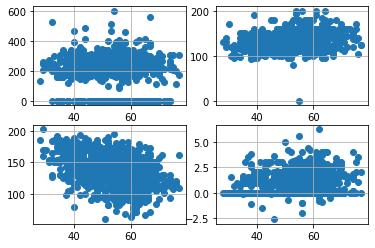

In [8]:
heart_dat = encoder_data_processing(idata)

    # scatter diagramms before preprocessing
plt.figure(1)
plt.subplot(2,2,1)
plt.scatter(heart_dat['Age'], heart_dat['Cholesterol'])
plt.grid()
plt.subplot(2,2,2)
plt.scatter(heart_dat['Age'], heart_dat['RestingBP'])
plt.grid()
plt.subplot(2,2,3)
plt.scatter(heart_dat['Age'], heart_dat['MaxHR'])
plt.grid()
plt.subplot(2,2,4)
plt.scatter(heart_dat['Age'], heart_dat['Oldpeak'])
plt.grid()

In [ ]:
# In the first picture we can see zero samples. Next step is processed this data

In [9]:
    # zero data processing (0 - delete rows; 1 - zero rows to median values)
preprocessed_heart_dat = missed_data_processing(heart_dat, 'Cholesterol', 0)
preprocessed_heart_dat = missed_data_processing(preprocessed_heart_dat, 'RestingBP', 0)
preprocessed_heart_dat = missed_data_processing(preprocessed_heart_dat, 'MaxHR', 0)

    # abnormal data processing
preprocessed_heart_dat = abnormal_data_processing(preprocessed_heart_dat, 'Cholesterol', 1)
preprocessed_heart_dat = abnormal_data_processing(preprocessed_heart_dat, 'RestingBP', 1)
preprocessed_heart_dat = abnormal_data_processing(preprocessed_heart_dat, 'MaxHR', 1)

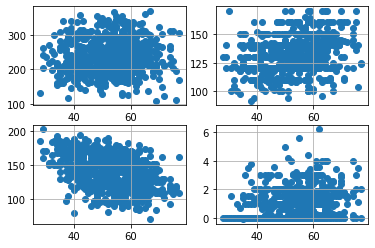

In [12]:
    # scatter diagramms after preprocessing
plt.figure(2)
plt.subplot(2,2,1)
plt.scatter(preprocessed_heart_dat['Age'], preprocessed_heart_dat['Cholesterol'])
plt.grid()
plt.subplot(2,2,2)
plt.scatter(preprocessed_heart_dat['Age'], preprocessed_heart_dat['RestingBP'])
plt.grid()
plt.subplot(2,2,3)
plt.scatter(preprocessed_heart_dat['Age'], preprocessed_heart_dat['MaxHR'])
plt.grid()
plt.subplot(2,2,4)
plt.scatter(preprocessed_heart_dat['Age'], preprocessed_heart_dat['Oldpeak'])
plt.grid()

In [ ]:
# zero data was processed

<Figure size 432x288 with 0 Axes>

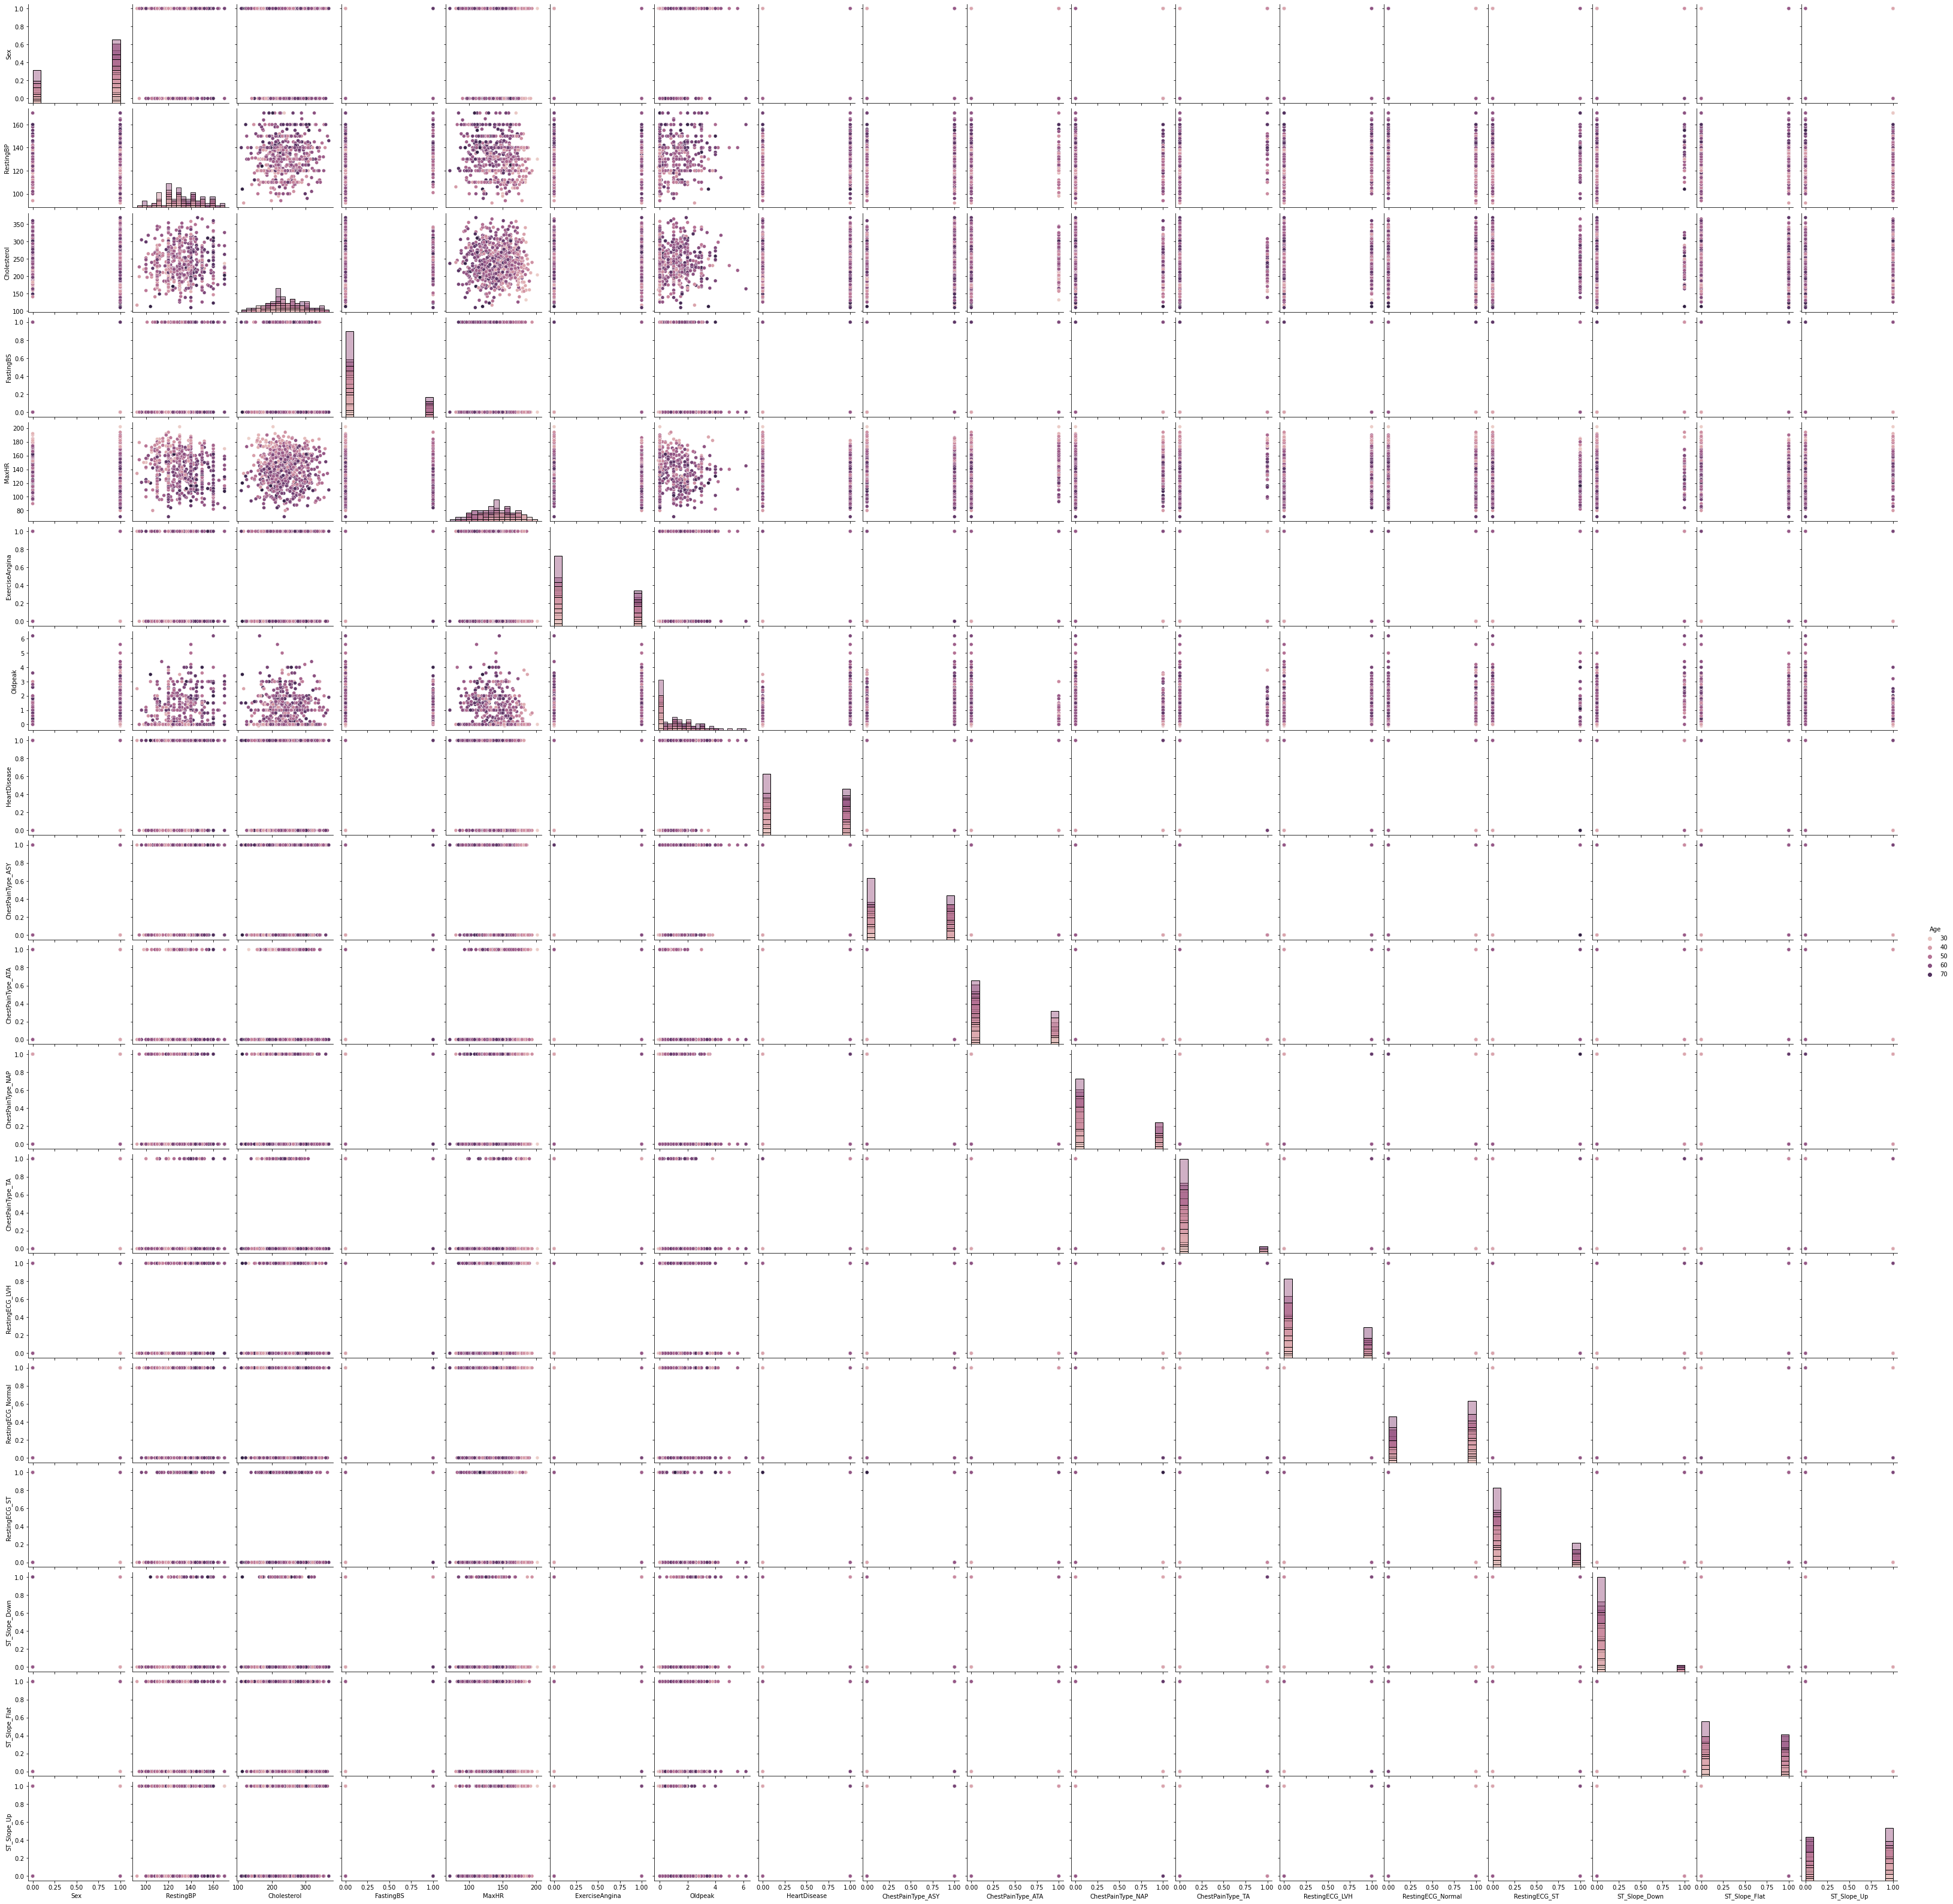

In [13]:
# scatter diagramm for all features
plt.figure(3)
sns.pairplot(preprocessed_heart_dat, hue='Age', diag_kind='hist')

Text(0.5, 1.0, 'corr matrix')

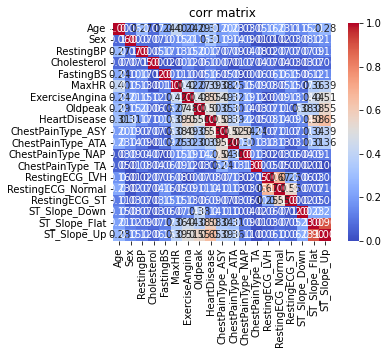

In [14]:
    # correlation matrix
plt.figure(4)
corr_mat = preprocessed_heart_dat.corr()
sns.heatmap(abs(corr_mat), square=True, annot=True, fmt='.2f', vmin=0, vmax=1, cmap='coolwarm')
plt.title('corr matrix')

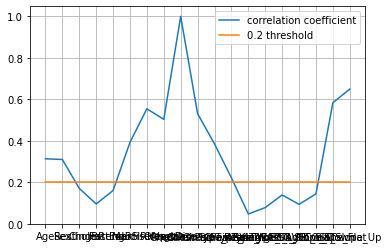

In [28]:
# correlation coeffisient between HeartDisease and features
plt.figure(5)
plt.plot(abs(corr_mat['HeartDisease']))
plt.plot(corr_mat.keys(), 0.2*np.ones(len(corr_mat.keys())))
plt.grid()
plt.legend(['correlation coefficient', '0.1 threshold'])
ids = corr_mat['HeartDisease'][abs(corr_mat['HeartDisease']) < 0.1]

In [17]:
# classification
    # Scaling Features to [0, 1] limit
min_max_scaler = MinMaxScaler()
min_max_scaler.fit_transform(preprocessed_heart_dat)
preprocessed_heart_dat = pd.DataFrame(min_max_scaler.transform(preprocessed_heart_dat), columns=preprocessed_heart_dat.columns, index=preprocessed_heart_dat.index)

    # test, train, validation split
dataX = preprocessed_heart_dat.loc[:, preprocessed_heart_dat.columns != 'HeartDisease']
dataY = preprocessed_heart_dat['HeartDisease']
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15
x_train, x_test, y_train, y_test = train_test_split(dataX, dataY, test_size=1 - train_ratio)

In [ ]:
# KNeighborsClassifier
knc = KNeighborsClassifier(n_neighbors=5)
knc.fit(x_train, y_train)
knc_y_predict = knc.predict(x_test)
print('KNeighborsClassifier: ', accuracy_score(knc_y_predict, y_test))

# DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth = 8, random_state=0)
dtc.fit(x_train, y_train, sample_weight=None, check_input=True)
dtc_y_predict = dtc.predict(x_test, check_input=True)
print('DecisionTreeClassifier: ', accuracy_score(dtc_y_predict, y_test))

# RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 50, max_depth = 10, random_state=0)
rfc.fit(x_train, y_train)
rfc_y_predict = rfc.predict(x_test)
print('RandomForestClassifier: ', accuracy_score(rfc_y_predict, y_test))

# BaggingClassifier
bc = BaggingClassifier(base_estimator=SVC(), n_estimators=50, random_state=0)
bc.fit(x_train, y_train)
bc_y_predict = bc.predict(x_test)
print('BaggingClassifier: ', accuracy_score(bc_y_predict, y_test))

Text(0.5, 1.0, 'RandomForestClassifier')

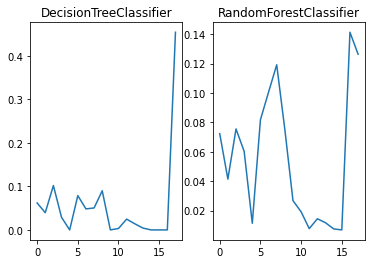

In [19]:
plt.figure(6)
plt.subplot(1,2,1)
plt.plot(dtc.feature_importances_)
plt.title('DecisionTreeClassifier')
plt.subplot(1,2,2)
plt.plot(rfc.feature_importances_)
plt.title('RandomForestClassifier')

In [ ]:
# drop columns with correlation coef between classes (HeartDisease) and features is small
preprocessed_heart_dat = preprocessed_heart_dat.drop(ids, axis = 1)

# KNeighborsClassifier
knc = KNeighborsClassifier(n_neighbors=5)
knc.fit(x_train, y_train)
knc_y_predict = knc.predict(x_test)
print('KNeighborsClassifier: ', accuracy_score(knc_y_predict, y_test))

# DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth = 8, random_state=0)
dtc.fit(x_train, y_train, sample_weight=None, check_input=True)
dtc_y_predict = dtc.predict(x_test, check_input=True)
print('DecisionTreeClassifier: ', accuracy_score(dtc_y_predict, y_test))

# RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 50, max_depth = 10, random_state=0)
rfc.fit(x_train, y_train)
rfc_y_predict = rfc.predict(x_test)
print('RandomForestClassifier: ', accuracy_score(rfc_y_predict, y_test))

# BaggingClassifier
bc = BaggingClassifier(base_estimator=SVC(), n_estimators=50, random_state=0)
bc.fit(x_train, y_train)
bc_y_predict = bc.predict(x_test)
print('BaggingClassifier: ', accuracy_score(bc_y_predict, y_test))

IndexError: index 18 is out of bounds for axis 0 with size 18

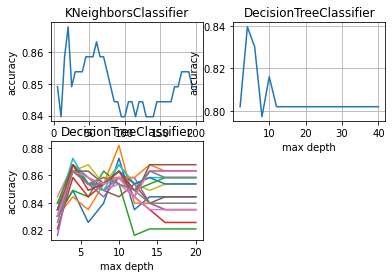

In [20]:
# classification different parameters
# KNeighborsClassifier
n_neighbors_arr = np.linspace(5, 200, 40, dtype = int)
knc_accuracy = np.zeros(40)
for i in range(len(n_neighbors_arr)):
    knc = KNeighborsClassifier(n_neighbors=n_neighbors_arr[i])
    knc.fit(x_train, y_train)
    knc_y_predict = knc.predict(x_test)
    knc_accuracy[i] = accuracy_score(knc_y_predict, y_test)

# DecisionTreeClassifier
max_depth_dt_arr = np.linspace(2, 40, 20, dtype = int)
dtc_accuracy = np.zeros(20)
for i in range(len(max_depth_dt_arr)):
    dtc = DecisionTreeClassifier(max_depth = max_depth_dt_arr[i], random_state=0)
    dtc.fit(x_train, y_train, sample_weight=None, check_input=True)
    dtc_y_predict = dtc.predict(x_test, check_input=True)
    dtc_accuracy[i] = accuracy_score(dtc_y_predict, y_test)
    


# RandomForestClassifier
n_estimators_rfc_arr = np.linspace(10, 100, 18, dtype = int)
max_depth_rf_arr = np.linspace(2, 20, 10, dtype = int)
rfc_accuracy = np.zeros([18, 10])
for i in range(len(n_estimators_rfc_arr)):
    for j in range(len(max_depth_rf_arr)):
        rfc = RandomForestClassifier(n_estimators = n_estimators_rfc_arr[i], max_depth = max_depth_rf_arr[j], random_state=0)
        rfc.fit(x_train, y_train)
        rfc_y_predict = rfc.predict(x_test)
        rfc_accuracy[i][j] = accuracy_score(rfc_y_predict, y_test)


# BaggingClassifier
n_estimators_bc_arr = np.linspace(5, 200, 40, dtype = int)
bc_accuracy = np.zeros(40)
for i in range(len(n_estimators_bc_arr)):
    bc = BaggingClassifier(base_estimator=SVC(), n_estimators=n_estimators_bc_arr[i], random_state=0)
    bc.fit(x_train, y_train)
    bc_y_predict = bc.predict(x_test)
    bc_accuracy[i] = accuracy_score(bc_y_predict, y_test)
  
    
plt.figure(7)
plt.subplot(2,2,1)
plt.plot(n_neighbors_arr, knc_accuracy)
plt.title('KNeighborsClassifier')
plt.grid()
plt.xlabel('number neighbors')
plt.ylabel('accuracy')

plt.subplot(2,2,2)
plt.plot(max_depth_dt_arr, dtc_accuracy)
plt.title('DecisionTreeClassifier')
plt.grid()
plt.xlabel('max depth')
plt.ylabel('accuracy')

for i in range(len(n_estimators_rfc_arr)):
    plt.subplot(2,2,3)
    plt.plot(max_depth_rf_arr, rfc_accuracy[i][0:])
    plt.title('DecisionTreeClassifier')
    plt.grid()
    plt.xlabel('max depth')
    plt.ylabel('accuracy')
plt.legend(n_estimators_rfc_arr)
plt.grid()


plt.subplot(2,2,4)
plt.plot(n_estimators_bc_arr, bc_accuracy)
plt.title('BaggingClassifier')
plt.grid()
plt.xlabel('number estimators')
plt.ylabel('accuracy')